# Neural Fitted Q (NFQ)

In reinforcement learning, we build agents that are capable of learning from feedback that is simultaneously **evaluative, delayed, and sampled**. 

**Delayed feedback**: imagine a chess game in which you make a few wrong moves early on, but the consequences only manifest at the end of the game. Delayed feedback makes it tricky to interpret the source of the feedback and rise the **temporal credit assignment problem**: the challenge of determining which state, action, or state-action pair is responsible for a reward. The opposite is **immediate feedback**. In supervised learning decisions don’t have long-term consequences. For example, in a classification problem, classifying an image, whether correctly or not, has no bearing on future performance.

![](./images/sequential-feedback-challenge.png)

**Evaluative feedback**: the goodness of the feedback is only relative, because the environment is uncertain. The agent doesn’t know the actual dynamics of the environment (no access to the transition and reward functions). As a result, the agent must explore the environment, but the  problem is that by exploring the agent misses capitalizing on its current knowledge. This is the exploration-exploitation trade-off. The opposite is **supervised feedback**. In a classification problem, during learning, the model is given the correct labels for each of the samples provided: there’s no guessing. 

![](./images/evaluative-feedback-challenge.png)

**Sampled feedback**: in real problems, agents are unlikely to sample all possible feedback exhaustively. Agents **need to generalize** using the gathered feedback and come up with intelligent decisions based on that generalization. The opposite is **exhaustive feedback**, where agents have access to all possible samples. Tabular reinforcement learning only needs to sample for long enough to gather all necessary information for optimal performance and they have optimal convergence guarantees. Common assumptions, such as "sampling every state-action pair infinitely often", are reasonable assumptions in small grid worlds with finite state and action spaces, but not in real settings. Consider for example an agent that play a video game:

![](./images/sampled-feedback-challenge.png)

The vast number of states in a video game highlights the limitations of traditional tabular reinforcement learning and necessitates the use of learning methods which can handle high-dimensional state spaces and learn effective policies.

## The need for generalization

The main drawback of the methods that we have seen so far is that they use of a table to represent value functions (for this reason we call them ) **tabular reinforcement learning**) and this is **no practical for complex problems**. For example, Q-learning estimates the values of the optimal value function using a matrix indexed by states and actions:

![](./images/tabular-value-function.png)

In many of the tasks to which we would like to apply reinforcement learning **the state space is combinatorial and enormous**. Environments can have **high-dimensional state spaces** (the number of variables that comprise a single state is vast) or can additionally have **continuous variables** (a single variable can take on an infinite number of values). How do we make a table that takes all these values into account? We can **discretize the state space**, but they can still take on a large number of values. Tabular solutions are **impractical** for the size of matrices. Moreover, the problem is not just the memory needed for large tables, but **the time needed to fill them accurately**. In many of our target tasks, **almost every state encountered will never have been seen before**. To make sensible decisions it is necessary **to generalize** from previous encounters with different states that are **in some sense similar** to the current one. Tabular solutions are **inefficient** also for the **lack of generalization**, that can discover underlying relationships. But, how can experience with a limited subset of the state space be usefully generalized to produce a good approximation over a much larger subset? Of course, in those conditions, we cannot expect to find optimal policies, our goal should be instead to find **good approximate solutions** using **limited computational resources**.  

**Generalization from examples** has already been extensively studied, and we do not need to invent totally new methods for use in reinforcement learning. To some extent we need only **combine reinforcement learning methods with existing generalization methods**. The kind of generalization we require is often called **function approximation**, because it takes examples from a desired function (e.g., a value function) and attempts to generalize from them to construct an approximation of the entire function. Function approximation is an instance of **supervised learning**. In theory, any of the methods studied in the field of machine learning can be used in the role of function approximator within reinforcement learning algorithms, although in practice some fit more easily into this role than others.

## The Cart-pole environment

In order to illustrate the need for generalization, we will use a classic controlo problem, the **Cart-pole**. The goal is to balance a pole on a cart that can move along a frictionless track. The pole starts upright and the goal is to prevent it from falling over by applying forces to the cart. The state space is low dimensional but **continuous**. Training is fast, yet still somewhat challenging, and function approximation can help. 

![](./images/cart-pole-environment.png)

The state space is comprised of four variables: 

- position of the cart on the track (x) with a range from –2.4 to 2.4; 
- velocity of the cart along the track (vc) with a range from –inf to inf; 
- angle of the pole (theta) with a range of –40 degrees to 40 degrees; 
- velocity at the tip (vp) of the pole with a range of –inf to inf.

There are two available actions in every state: 

- action 0 applies a –1 force to the cart (push it left)
- action 1 applies a +1 force to the cart (push it right)

The cart reach a terminal state if: 

- the angle theta is more than 12 degrees away from the vertical position; 
- the center or the cart is more than 2.4 units from the center of the track; 
- the episode count reaches 500 time steps. 

The reward function is +1 for every time step. The environtment is available in the Gymnasium library.

In [2]:
import gymnasium

cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array");

We can get the state space and the action space sizes of the environment:

In [4]:
state_size = cartpole.observation_space.shape;
action_size = cartpole.action_space.n;

print('State Space: ', state_size);
print('Action Space: ', action_size);

State Space:  (4,)
Action Space:  2


We want to be able to reproduce the results, so we will fix the random seed:

In [6]:
import torch;
import numpy as np;
import random;

# set the seeds for reproducibility of results
seed = 34;

torch.manual_seed(seed);
np.random.seed(seed);
random.seed(seed);
cartpole.np_random = np.random.Generator(np.random.PCG64(seed));

We can show the environment with a random policy:

In [7]:
def random_pi(state, q):
    return np.random.choice([0,1]);

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, q, n_episodes=1, max_steps=500):
    for _ in range(n_episodes):
        state = env.reset()[0];
        done = False;
        step = 0;
        while not done:
            action = pi(state, q);
            state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated): done = True;
            clear_output(wait=True);
            plt.imshow(env.render());
            plt.show(); 
            if step > max_steps: break;
            step += 1;   

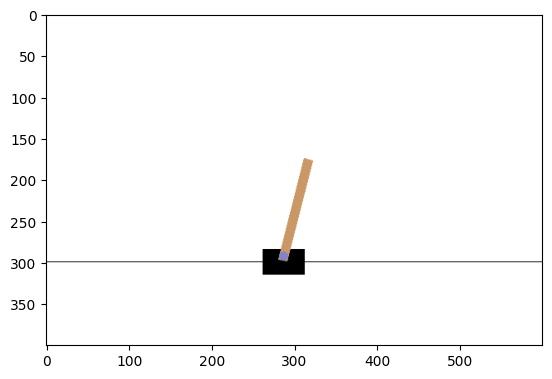

In [10]:
show_policy(cartpole, random_pi, None, n_episodes=1, max_steps=500);

We need a function in order to evaluate the performance of the agent. We will use the average reward over a number of episodes as our metric:

In [11]:
def evaluate(env, pi, q, episodes=1):
    rewards = [];

    for episode in range(episodes):
        state, done = env.reset()[0], False;
        rewards.append(0);
        while not done:
            action = pi(state, q);
            state, reward, terminal, truncated, info = env.step(action)
            rewards[-1] += reward;
            done = terminal or truncated;

    return np.mean(rewards);

In [62]:
random_score = evaluate(cartpole, random_pi, None, episodes=100);
print("Random score", random_score);

Random score 21.53


The random agent has a very low performance, it is able to balance the pole for a very short time. We can try to solve the environment using Reinforcement Learning methods. However, it in not possible to apply tabular reinforcement learning methods to this environment because the state space is continuous. We need to use function approximation in order to generalize.

## Fully Connected Q-function

The Neural Fitted Q ([M. Riedmiller, "Neural fitted Q iteration – first experiences with a data efficient neural reinforcement learning method", ECML (2005)](./papers/2005%20-%20Neural%20Fitted%20Q%20Iteration%20−%20First%20Experiences%20with%20a%20Data%20Efficient%20Neural%20Reinforcement%20Learning%20Method.pdf) is one of the first algorithms to successfully **use neural networks as a function approximation** to solve reinforcement learning problems. We refer to the approximate action-value function estimate as: 

$\displaystyle Q(s,a; \theta)$

which means the estimate is parameterized by the weights of a neural network. In order to design the function approximator, we can observe that the matrix holding the action-value function was indexed by state and action pairs, so a straightforward neural network architecture can take in input the state and the action to evaluate, and it can output a single value representing the value for that state-action pair:

![](./images/nfq-nn-1.png)

This architecture would work fine, but a more efficient one consists of **only inputting the state to the neural network and outputting the Q-values for all the actions** in that state:

![](./images/nfq-nn-2.png)

This is clearly advantageous when using exploration strategies such as epsilon-greedy or softmax, because we can have having to do **only one pass forward to get the values of all actions**. 

In a neural network-based approach, the state is passed through the network, which learns to approximate the action value function and the policy. This bypasses the need to explicitly store values for every state-action pair, as the network can generalize across states by learning patterns from the data. This generalization is critical in large or continuous environments where it’s impossible to enumerate or store all possible states. Moreover, the parameters of the DNN are learned through experience and adjusted using gradient-based optimization, allowing the policy to improve over time by tweaking the network’s internal weights. Thus, with this DNN-based method we can handle complex, high-dimensional spaces efficiently:

![](./images/nfq-architecture.png)

We can implement the function approximator as a **fully Connected network** using a machine learning library, such as PyTorch. The network will have two hidden layers with some neurons each (e.g. for the cartpole case 512 and 128 neuron are enough) and a ReLU activation function. The output layer will have a linear activation function, because we want to output the values directly. The input layer will have four neurons, one for each of the state variables: 

In [63]:
dnn = torch.nn.Sequential(
        torch.nn.Linear(state_size[0], 512),  
        torch.nn.ReLU(),                           
        torch.nn.Linear(512, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, action_size));

Using the neural network that estimates the Q-values, we can create a policy by acting greedily with respect to the Q-values:

In [64]:
def pi(state, q):
        # convert the state into a tensor
        state = torch.FloatTensor(state);

        # calculate q_values from the network
        q_values = q(state).detach();

        # act greedy
        action = np.argmax(q_values).data.numpy();

        return action;

## Training

To train a neural network we need to define a **Loss function**, which is a measure of how well a neural network predictions are. In supervised learning, it’s straightforward to define. We have a dataset of examples, and we know the correct output for each example. In that case, the loss function computes a distance score indicating how well the network has done on the datase. There are many different ways for calculating this distance score, one of the most common ones is MSE (**mean squared error**, or L2 loss). It is defined as the average squared difference between the "predicted" and "true" values. In our case, we have two problems. The first one is that **we don't have any dataset**, we need to collect experiences from the environment. The second one is that **we don't have access to the "true" values**. An ideal objective would be to calculate the loss with respect to the "true" (optimal) action-value function q* calulated over the experieces that we have collected:

$\displaystyle L(\theta)=E_{s,a}[(q_*(s,a)-Q(s,a;\theta))^2]$

Obviously, we are not talking about having access to q* (otherwise, there’s no need for learning), but we can use the same principles learned in generalized policy iteration, in which we **alternate between policy-evaluation and policy-improvement processes** to find good policies. However, because we’re using non-linear function approximation, **convergence guarantees no longer exist**. In the NFQ implementation we do just that: we start with a randomly initialized action-value function (and implicit policy), then we evaluate the policy by sampling actions from it, we improve it with an exploration strategy (such as epsilon-greedy) and finally, we keep iterating until we reach the desired performance. So, **we use as "true values" the targets**, which depend on a prediction also coming from the network, the value of the next state, in a circular dependency:

![](./images/circular-dependencies.png)

As you may be thinking, **this circular dependency is bad**. It’s not well behaved because **it doesn’t respect several of the assumptions made in supervised learning problems**. However, we can goes on and see what we can do with it. Ass your remember, there are different targets we can use for estimating the action-value function of a policy: Monte Carlo (MC) target, Temporal-Difference (TD) target, n-Step target, and Lambda target:

![](./images/target-estimations.png)

The target can be either on-policy (like in SARSA) or off-policy (like in Q-learning), depending on the way we bootstrap. The two main ways are to either use the action-value function of the action the agent will take at the landing state, or alternatively, to use the value of the action with the highest estimate at the next state:

$\displaystyle Q^\text{SARSA}(S_t, A_t) = Q(S_t, A_t) + \alpha  [ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) ]$

$\displaystyle Q^\text{Q-learning}(S_t, A_t) = Q(S_t, A_t) + \alpha [ R_{t+1} + \gamma  \underset{a}{\text{ max }} Q(S_{t+1}, a) - Q(S_t, A_t) ]$

Using those rules we can define the loss function as the difference between the current Q-value and the new value that should be assigned. For example, a squared-error measure like the following can be used:

$\displaystyle L(\theta)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta) - Q(s,a;\theta))^2 \right]$

In order to minimize the loss function we can use a standard optimization methods in supervised learning, like **Batch Gradient Descent (BGD)**, it takes the entire dataset at once, calculates the gradient of the dataset and steps toward this gradient a little bit at a time. Then, it repeats this cycle until convergence:

![](./images/BGD.png)

When we have a considerable dataset with millions of samples, BGD is too slow to be practical. Moreover, in reinforcement learning, **we don’t even have a dataset in advance, so batch gradient descent isn’t a practical method for our purpose**. An optimization method capable of handling smaller batches of data is called **Mini-Batch Gradient Descent (MGD)**, where we use only a fraction of the data at a time:

![](./images/MBGD.png)

We can control the size of the mini-batches, which allows the processing of large datasets. At one extreme, we can set the size of mini-batch to the size of the dataset (BGD) at the other extreme, we can set the size to a single sample (**Stochastic Gradient Descent (SGD)**). The larger the batch, the lower the variance the steps of the optimization method have, but learning slows down considerably. An improved algorithm is called **Gradient Descent with Momentum**. This is a MBGD that updates the weights of the network in the direction of the moving average of the gradients, instead of the gradient itself:

![](./images/MomentumGD.png)

However, these algorithms require a couple of assumptions: data must be **independent and identically distributed (IID)** and targets must be **stationary**. In reinforcement learning we cannot ensure any of these assumptions. So choosing a robust optimization method to minimize the loss function can often make the difference between convergence and divergence. In practice, **Root Mean Square propagation (RMSprop)** (that reduces oscillations of Momentum by scaling the gradient in proportion to the average magnitude of recent gradients) and **Adaptive Moment Estimation (Adam)** (that steps in the direction of the velocity of the gradients as momentum, but it scales updates in proportion to the moving average of the magnitude of the gradients as RMSprop) are sensible choices for reinforcement learning:

In [65]:
learning_rate = 0.0007;
optimizer = torch.optim.RMSprop(dnn.parameters(), lr=learning_rate);

All optimization methods are based on gradient calculation. It's important to note that when differentiating the loss function, the gradient is computed solely with respect to the predicted values, not the target values (this is a common source of error). In supervised learning, "predicted values" come from the model, while "true values" are constants provided in advance. In reinforcement learning, however, the "true values" depend on the predicted values themselves, as they are generated by the model. **Although this value is not a true constant, it should be treated as one during the optimization**:

$\displaystyle \nabla_{\theta_i} L(\theta)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta) - Q(s,a;\theta)) \nabla_{\theta} Q(s,a;\theta) \right]$

The problem with this on-line update rule is that if weights are adjusted for one certain state action pair, then unpredictable changes also occur at other places in the state-action space. Although in principle this could also have the positive effect of generalization, in many cases this seems to be the main reason for unreliable and slow learning. So the basic idea of NFQ is to  **update the neural value off-line, considering an entire set of transition experiences**. So we need to store a collection of experiences:

In [66]:
batch_size = 1024;

experience_type = np.dtype([
    ('state', np.float32, (state_size)), 
    ('action', np.int8),                  
    ('reward', np.float32),               
    ('next_state', np.float32, (state_size)),  
    ('failure', np.int8)                  
])

experiences_batch = np.empty(shape=(batch_size,), dtype=experience_type);

Moreover, we need to collect the batch of experiences from the environment using an exploration stratefy:

In [67]:
def epsilon_greedy(dnn, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size);
    else:
        # convert the state into a tensor
        state = torch.FloatTensor(state);
        # calculate q_values from the network
        q_values = dnn(state).detach();
        # act greedy
        action = np.argmax(q_values).data.numpy();
        return action; 

Then we can optimize the network using the collected experiences, the loss fucntion and the backpropagation algorithm:

In [68]:
def optimize(dnn, optimizer, batch, gamma, epochs):

    # prepare the experience as tensors
    states = torch.from_numpy(batch['state'].copy()).float();
    actions = torch.from_numpy(batch['action'].copy()).long();    
    next_states = torch.from_numpy(batch['next_state'].copy()).float();
    rewards = torch.from_numpy(batch['reward'].copy()).float();
    failures = torch.from_numpy(batch['failure'].copy()).long();

    for epoch in range(epochs):

        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants! 
        q_next = dnn(next_states).detach();
        
        # get the max value 
        max_q_next = q_next.max(1)[0];

        # one important step, often overlooked, is to ensure 
        # that failure states are grounded to zero
        max_q_next *= (1 - failures.float());

        # calculate the target 
        target = rewards + gamma * max_q_next;

        # finally, we get the current estimate of Q(s,a)
        q_current = torch.gather(dnn(states), 1, actions.unsqueeze(1)).squeeze(1);

        # create the errors
        td_error = target - q_current;

        # calculate the loss
        loss = td_error.pow(2).mean();

        # backward pass: compute the gradients
        optimizer.zero_grad();
        loss.backward();

        # update model parameters
        optimizer.step();

    return loss;

## NFQ Algorithm

Now we can put things together and consider the full algorith: 

1. use a fully connected neural network with states as input and actions as output; 
2. use an epsilon-greedy strategy to explore the environment and to collect some experiences (e.g. 1024 samples);
3. calculate the off-policy targets;
4 fit the action-value function using MSE for the loss function and RMSprop as optimizer;
4. repeats steps 3 and 4 a number of times (epochs) before going back to step 2;

![](./images/nfq-algorithm.png)

We can write this process and apply it to the Cart-pole environment:

In [69]:
def nfq(env, dnn, optimizer, batch, exploration_strategy,
        max_episodes, epochs, gamma, epsilon):

    # create a batch index
    index = 0;

    # create a score tracker for statistic purposes and a window
    # to average the score over some episodes to smooth the curve
    scores = [];

    # train until for the maximum number of episodes
    for episode in range(max_episodes):

        # reset the environment at the beginning of the episode
        state, done = env.reset()[0], False;

        # interact with the environment until the episode is done
        while not done:
                
            # select the action using the exploration policy
            action = exploration_strategy(dnn, state, action_size, epsilon);
            
            # perform the selected action
            next_state, reward, terminal, truncated, info = env.step(action);
            done = terminal or truncated;
            failure = terminal and not truncated;

            # store the experience
            batch[index] = (state, action, reward, next_state, failure);
            index += 1;
            
            # if the experience collected so far is enough...
            if index == len(batch):
                # optimize the model
                optimize(dnn, optimizer, batch, gamma, epochs);
                # and clear the buffer
                index = 0;
                batch = np.empty(shape=(len(batch),), dtype=experience_type);

            # update current state to next state
            state = next_state;

        # After each episode, evaluate the policy
        score = evaluate(env, pi, dnn, episodes=3);

        # store the score in the tracker
        scores.append(score);
        
        # print some informative logging 
        message = 'Episode {:03}, score {:05.1f}';
        message = message.format(episode+1, score);
        print(message, end='\r', flush=True);
        
    return scores;


We can apply the algorithm to the Cart-pole environment:

In [70]:
# define hyperparameters values
max_episodes = 1000; 
batch_size = 1024; 
epochs = 32; 
gamma = 0.99;
epsilon = 0.5; 

# run the algorithm
nfq(cartpole, dnn, optimizer, experiences_batch, epsilon_greedy,  
    max_episodes, epochs, gamma, epsilon);

We can evaluate the performance of the learned agent versus the random one:

In [71]:
agent_score = evaluate(cartpole, pi, dnn, episodes=10);

print("Random score", random_score);
print("Agent score", agent_score);

Random score 21.53
Agent score 336.5


And we can see the agent in action:

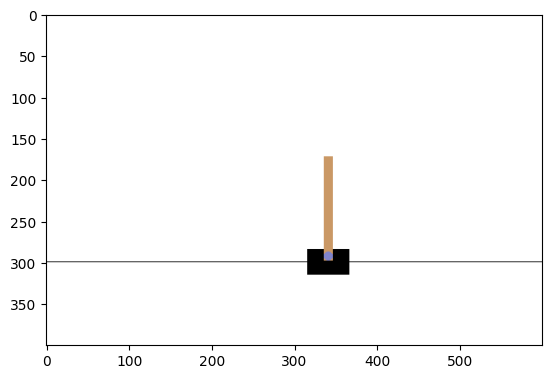

: 

In [ ]:
show_policy(cartpole, pi, dnn, n_episodes=1, max_steps=500);

The agent is good enough to balance the pole for a considerable amount of time. Howerver, we don't have any information about the performance of the algorithm, we can try to understand how the agent is learning by plotting some quantities over time setting up an experiment.

## Experiment

To understand how the agent is learning, we can conduct an experiment to collect the average scores achieved by the algorithm after a certain number of episodes:

In [60]:
def experiment(env, seeds = (12, 34, 56, 78, 90), 
               batch_size = 1024, epochs = 40, gamma = 0.99, 
               epsilon = 0.5, learning_rate = 0.0005,
               max_episodes=1000, sliding_windows=10):

    # variable to collect results
    results = [];
    
    # run the experiments for each seed
    for seed in seeds:

        print("Experiment seed: ", seed);
        
        # set the seeds for reproducibility of results
        torch.manual_seed(seed);
        np.random.seed(seed);
        random.seed(seed);
        env.np_random = np.random.Generator(np.random.PCG64(seed));

        # reset the environment
        env.reset();

        # create a new model
        dnn = torch.nn.Sequential(
            torch.nn.Linear(state_size[0], 512),  
            torch.nn.ReLU(),                           
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, action_size));

        # create the optimizer
        optimizer = torch.optim.RMSprop(dnn.parameters(), lr=learning_rate);

        # create the experience batch
        batch = np.empty(shape=(batch_size,), dtype=experience_type);

        # train the network
        scores = nfq(env, dnn, optimizer, batch, epsilon_greedy,  
                     max_episodes, epochs, gamma, epsilon);
        
        # smooth the result using a sliding window
        scores = np.convolve(scores, np.ones(sliding_windows)/sliding_windows, mode='valid');
        
        # collect the results
        results.append(scores);

        print("");

    return results;

We can repeat the experiment multiple times, changing the random number generator seed each time, to evaluate the stability of the algorithm:

In [61]:
# run the experiments
results = experiment(cartpole);

Experiment seed:  12
Episode 1000, score 496.0
Experiment seed:  34
Episode 1000, score 375.0
Experiment seed:  56
Episode 1000, score 489.0
Experiment seed:  78
Episode 1000, score 500.0
Experiment seed:  90
Episode 1000, score 011.7


While NFQ may not be considered a state-of-the-art solution, it demonstrates decent performance in relatively simple environments like CartPole. As observed during the simulations, the algorithm converges differently when initialized with various random seeds. This variability indicates that the algorithm lacks stability, resulting in significant fluctuations in performance.  We perform basic statistical analysis on the experimental data to calculate the maximum, minimum, and mean scores for each step. This helps us assess both the stability of the performance (how close the scores are to the mean) and its quality (how close the scores are to the maximum):

In [62]:
max_score = np.max(results, axis=0).T;
min_score = np.min(results, axis=0).T;
mean_score = np.mean(results, axis=0).T;

experiment_results = {
        'max_score': max_score,
        'min_score': min_score,
        'mean_score': mean_score,
    }

Then we can save results on a file to compare with other algorithms:

In [63]:
import joblib
joblib.dump(experiment_results, '../models/nfq_results.joblib');

Now we can plot the averate scores obtained by the agent over different training episodes:

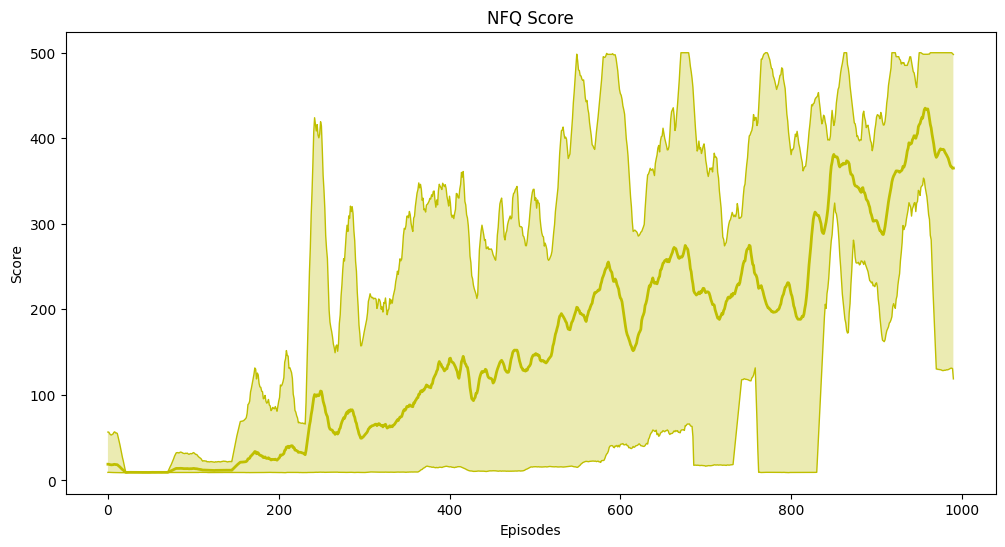

In [64]:
plt.figure(figsize=(12,6));
plt.title('NFQ Score');
plt.ylabel('Score');
plt.xlabel('Episodes');
episodes = range(len(experiment_results['max_score']));
plt.plot(experiment_results['max_score'], 'y', linewidth=1)
plt.plot(experiment_results['min_score'], 'y', linewidth=1)
plt.plot(experiment_results['mean_score'], 'y', linewidth=2)
plt.fill_between(episodes, experiment_results['max_score'], experiment_results['min_score'], facecolor='y', alpha=0.3);
plt.show();

The NFQ algorithm shows learning progress as the score increases, but there is **some instability** as indicated by the **high variance** in the scores and the growing gap between the max and min scores. The sliding average helps to highlight the trend in the data, showing that the agent is learning to balance the pole more effectively over time. Overall, in this simple environment, the algorithm is able to learn a good policy in a relatively short amount of time.

## Challenges

There are two issues with NFQ algorithm. First, we’re using a powerful function approximator, that can generalize across state-action pairs, which is excellent, but that also means that the neural network adjusts the values of all similar states at once. However, notice that **our target values depend on the values for the next state**. In other words, we’re creating a **non-stationary target** for our learning updates. As we update the weights of the approximate Q-function, the targets also move and make our most recent update outdated. Thus, training becomes **unstable** quickly:

![](./images/non-stationary-problem.png)

The way NFQ addresses the issue is through the use of **batching**. By growing a batch, we have the opportunity of optimizing several samples at the same time. The larger the batch, the more the opportunity for collecting a diverse set of experience samples. Second, we batched experience samples, collected online, and update the neural network from that mini-batch. However, these samples are **correlated**, they come from the same trajectory and policy. That means the network learns from mini-batches of samples that are similar, and later uses different mini-batches that are also internally correlated, but likely different from previous mini-batches. All this means that **we aren’t holding the IID assumption**, and this is a problem because optimization methods assume the data samples they use for training are independent and identically distributed. But we’re training on almost the exact opposite: **samples are not independent** (the outcome of a new state is dependent on current state); and, **samples aren’t identically distributed** (underlying data generating process, the policy, is changing over time). Optimization methods allow us to relax the IID assumption to a certain degree, but reinforcement learning problems go all the way, so we need to do something about this, too.